# Data Science Workshop
# NBA Free Throws Prediction

![title](img/free_throw_img.jpg)

In January 2015 a data-set of 600K NBA free-throws was upload to Kaggle by Sebastian-Mantey. The data was scraped from the website ESPN.com which belongs to an entertainment and sports programming network. 

Since the data-set was uploaded, 25 kernels were uploaded to Kaggle related to it. Most of the kernels summarize, analyze and visualize the data and do not try to predict anything. However, there are two interesting kernels:

The kernel ‘Shooting percentage over time’, engages with the questions How does the Free Throw shooting percent develop over time? Does it go down as the game approaches the ending due to higher pressure? Does it go up thanks to players being warmer, or alternatively - better shooters take the ball?

The findings of the analysis are that in the end of every quarter of a game, there is an increase in the number of free-throws and in the free-throws percentage. They also found that most of the throws in the end of every quarter were performed by better players, but still the absolute time of the throw affected the outcome more than how performed it. 

Another interesting kernel is ‘Pooling Partial Hierarchica via champs throw Free’, in which they try to find the best players in the data-set with statistical and probability methods such as complete pooling, and find the probability p for every player to succeed in the free-throw. 

Outside Kaggle, we found the article ‘Mindfulness and Free Throws’. This article investigate the relationship between mindfulness, preshot routine, and basketball free-throw percentage. The findings suggest that the combination of mindfulness levels, skill level (practice free-throw percentage), and competitive experience (year in school), all contribute to the prediction of competitive free throw percentage.


## Data preparation and cleaning


## Import Python Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline


## Reading the Original Dataset


In [2]:
free_throws_db = pd.read_csv('free_throws.csv')
free_throws_db.drop_duplicates()
free_throws_db.head(10)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45
2,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18-Dec,2006 - 2007,1,7:26
3,106 - 114,PHX - LAL,261031013,1,Andrew Bynum misses free throw 2 of 2,Andrew Bynum,regular,18-Dec,2006 - 2007,0,7:26
4,106 - 114,PHX - LAL,261031013,1,Shawn Marion makes free throw 1 of 1,Shawn Marion,regular,21-Dec,2006 - 2007,1,7:18
5,106 - 114,PHX - LAL,261031013,1,Amare Stoudemire makes free throw 1 of 2,Amare Stoudemire,regular,33 - 20,2006 - 2007,1,3:15
6,106 - 114,PHX - LAL,261031013,1,Amare Stoudemire makes free throw 2 of 2,Amare Stoudemire,regular,34 - 20,2006 - 2007,1,3:15
7,106 - 114,PHX - LAL,261031013,2,Leandro Barbosa misses free throw 1 of 2,Leandro Barbosa,regular,43 - 29,2006 - 2007,0,10:52
8,106 - 114,PHX - LAL,261031013,2,Leandro Barbosa makes free throw 2 of 2,Leandro Barbosa,regular,44 - 29,2006 - 2007,1,10:52
9,106 - 114,PHX - LAL,261031013,2,Lamar Odom makes free throw 1 of 2,Lamar Odom,regular,44 - 30,2006 - 2007,1,10:37


Describition of dataset:
- end_result: host total score - guest total score
- game: host team vs guest team
- game_id: id of specific game
- period: which quarter
- play: who make free throw, make or miss free throw
- player: player name
- playoffs: whether a playoff game or regular game
- score: host team score - guest team score at that time
- season: NBA season
- shot_made: whether player got the free throw
- time: time left in that quarter

In [3]:
print("Number of free throws in database: %d"%(free_throws_db.shape[0]))
print("Number of games in database: {}".format(free_throws_db.game_id.unique().size))
print("Games distribution:")
free_throws_db['playoffs'].value_counts()

Number of free throws in database: 618019
Number of games in database: 12874
Games distribution:


regular     575893
playoffs     42126
Name: playoffs, dtype: int64

## Collecting more data from internet

In order to expand our dataset, we decided to use an open source python library PandasBasketball, and use a webscrapper in order to get more players stats from https://www.basketball-reference.com website

Example of basketball-reference NBA player stats webpage:
![title](img/lebron_page_1.jpg)
![title](img/lebron_page_2.jpg)

And our code to extract from website html our data

In [4]:
from tools import get_player_stats
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='BeatifulSoup')
dataFrame = get_player_stats("Lebron James")
print(dataFrame.columns)
dataFrame.head(20)

Index(['Season', 'Age', 'Tm', 'Lg', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Height',
       'Weight', 'ShootingHand', 'draftRank'],
      dtype='object')


,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Height,Weight,ShootingHand,draftRank
0,2003-04,19,CLE,NBA,SG,79,79,3122,622,1492,...,465,130,58,273,149,1654,206,113,Right,1
1,2004-05,20,CLE,NBA,SF,80,80,3388,795,1684,...,577,177,52,262,146,2175,206,113,Right,1
2,2005-06,21,CLE,NBA,SF,79,79,3361,875,1823,...,521,123,66,260,181,2478,206,113,Right,1
3,2006-07,22,CLE,NBA,SF,78,78,3190,772,1621,...,470,125,55,250,171,2132,206,113,Right,1
4,2007-08,23,CLE,NBA,SF,75,74,3027,794,1642,...,539,138,81,255,165,2250,206,113,Right,1
5,2008-09,24,CLE,NBA,SF,81,81,3054,789,1613,...,587,137,93,241,139,2304,206,113,Right,1
6,2009-10,25,CLE,NBA,SF,76,76,2966,768,1528,...,651,125,77,261,119,2258,206,113,Right,1
7,2010-11,26,MIA,NBA,SF,79,79,3063,758,1485,...,554,124,50,284,163,2111,206,113,Right,1
8,2011-12,27,MIA,NBA,SF,62,62,2326,621,1169,...,387,115,50,213,96,1683,206,113,Right,1
9,2012-13,28,MIA,NBA,PF,76,76,2877,765,1354,...,551,129,67,226,110,2036,206,113,Right,1


Columns used for this database for each player:
- Position : The most common position for the player over his seasons.
- FG%
- 3P%
- FT%
- Height
- Weight
- ShootingHand
- draftRank

## We merged both the datasets according our collected data from internet.
Some players stats had been inserted manually because some bugs found on PandasBasketball library

In [5]:
database_p1 = pd.read_csv("complete_database.csv")
database_p2 = pd.read_csv("complete_database_part2.csv")
database = pd.concat([database_p1,database_p2])
database = database.drop(columns=['Unnamed: 0', 'Unnamed: 0'])
# Drop duplicated rows
database.drop_duplicates()
database.head(3)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,...,2P%,3P%,FT%,Height,Weight,draftRank,Pos,ShootingHand,Team,Difference
0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,...,0.557,0.111,0.296296,213,129,10,C,Right,LAL,1.0
1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,...,0.557,0.111,0.296296,213,129,10,C,Right,LAL,2.0
2,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,18-12,2006 - 2007,1,...,0.557,0.111,0.296296,213,129,10,C,Right,LAL,-6.0


## PrePrecessing the data 


### Specifing Data Types

In [6]:
binary_variables = ['shot_made', 'playoffs', 'ShootingHand']
categorical_variables = ['end_result', 'game', 'game_id', 'period', 'play', 'player', 'season']
numeric_variables = ['score','time','FG%','2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank', 'Pos']

In [7]:
database.count()

end_result      617786
game            617786
game_id         617786
period          617786
play            617786
player          617786
playoffs        617786
score           617786
season          617786
shot_made       617786
time            617786
FG%             617786
2P%             617786
3P%             612884
FT%             570699
Height          617786
Weight          617786
draftRank       617786
Pos             617786
ShootingHand    617786
Team            617786
Difference      617786
dtype: int64

We can see, we have only two columns with missing data. First - the draftRank column. 
This values are missing because the players performed the free throw didn't have a draft rank and not because we couldn't collect the data. Second - 3P% has missing values since there are players that have never throws a 3-pointer.

### processing the columns 
We will change the relevant categorical variable (only the position) to numeric and change the binary and numeric variables to be in the appropriate type.

In [8]:
# adding an abs_time column to our database:
database['minute'] = database.time.apply(lambda x: int(x[:len(x)-3]))
database['sec'] = database.time.apply(lambda x: int(x[len(x)-2:]))
database['abs_min'] = 12 - database['minute']+12*(database.period -1)
database['abs_time'] = 60*(database.abs_min-1) + 60 - database['sec']

# adding a scoreDif column that represents the difference in the groups scores in the time of the throw:
database['scores'] = database.score.replace(' - ', '-').apply(lambda x: x.split('-'))
database['scoreDif'] = database.scores.apply(lambda x: abs(int(x[1])-int(x[0])))

database.dtypes

end_result       object
game             object
game_id           int64
period            int64
play             object
player           object
playoffs         object
score            object
season           object
shot_made         int64
time             object
FG%             float64
2P%             float64
3P%             float64
FT%             float64
Height           object
Weight           object
draftRank        object
Pos              object
ShootingHand     object
Team             object
Difference      float64
minute            int64
sec               int64
abs_min           int64
abs_time          int64
scores           object
scoreDif          int64
dtype: object

## Analyzing the data 


### Analyzing the number of throws troughout the game

We would like to show the free throws distribution throughout the game time,
in our current dataset, the time column represents the time left in that quarter and the period column represents the quarter of the game, so we'll add a new column to our data which calculate the absolute time in the game that the throw was made.

In [9]:
#  counting the num of throws, and success throws precentage per minute
minutes = range(int(max(database.abs_min)))
total_throws = []
success_throws = []
success_precentage = []

def count_throws(database,minute):    
    made = len(database[(database.abs_min == minute) & (database.shot_made == 1)])
    success_throws.append(made)
    total = len(database[database.abs_min == minute])
    total_throws.append(total)
    if total == 0:
        precentage = 0.0
    else:
        precentage = made/total
    success_precentage.append(precentage)

for minute in minutes:
    count_throws(database,minute)

Text(0, 0.5, 'num of throws')

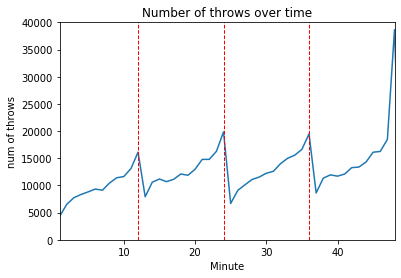

In [10]:
# Number of throws over time
plt.plot(minutes,total_throws)
plt.title('Number of throws over time')
plt.xlim([1,48])
plt.ylim([0, 40000])
plt.plot([12,12],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,40000], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,40000], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('num of throws')

Text(0, 0.5, 'Free Throws %')

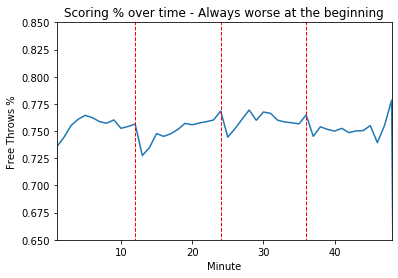

In [11]:
# Success throws precentage over time   
plt.plot(minutes,success_precentage)
plt.title('Scoring % over time - Always worse at the beginning')
plt.xlim([1,48])
plt.ylim([0.65,0.85])
plt.plot([12,12],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([24,24],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([36,36],[0,1], '--', linewidth = 1, color = 'r')
plt.plot([48,48],[0,1], '--', linewidth = 1, color = 'r')
plt.xlabel('Minute')
plt.ylabel('Free Throws %')

From the plots we can observe that at the begining of every querter, both the number of free throws and the success precentage drops.
Moreover, at the end of a quarter, and especially at the end of the game, both plots increase.
We can explain this behaivor, as basketball rules when a team made more than 5 fouls, every another foul made in that quarter will be penalty with a free throw.


### Analyzing the number of throws troughout the game
We want to see how the average of free throws attempted and succeed in games over our differents season in our dataset are distributed.

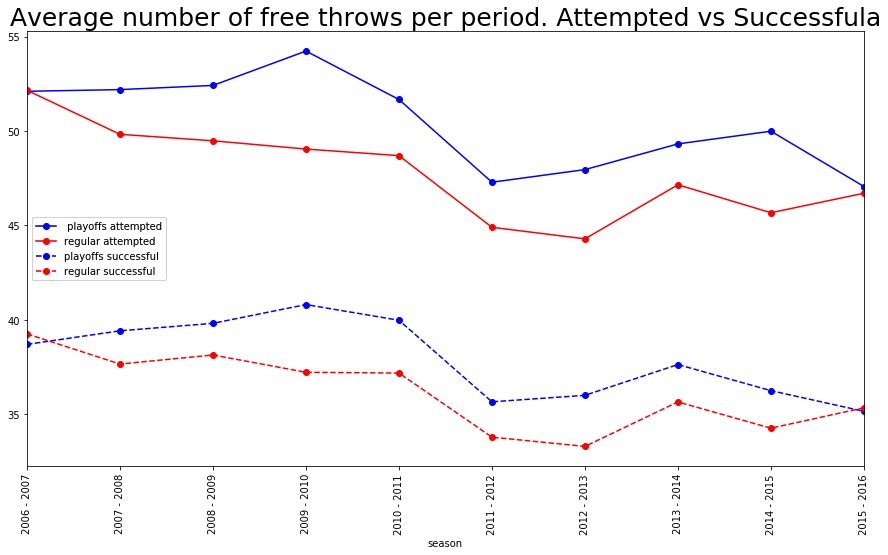

In [12]:
shot_attempted_per_game = database.groupby(["season", "playoffs"])['shot_made'].count().unstack()
shot_made_per_game = database.groupby(["season", "playoffs"])['shot_made'].sum().unstack()

# this has to be divided by the number of games for each season to get an average
number_of_games=database.groupby(["season", "playoffs"])['game_id'].nunique().unstack()

average_shot_made_per_game = shot_made_per_game/number_of_games
average_shot_attempted_per_game = shot_attempted_per_game/number_of_games


f, (ax1) = plt.subplots(figsize=(18,18))
first=average_shot_attempted_per_game.plot(ax=ax1, marker='o', figsize=(15,8), xticks=range(10), color=['b','r'], rot=90)
second=average_shot_made_per_game.plot(ax=ax1, marker='o', linestyle='--', figsize=(15,8), xticks=range(10), color=['b','r'], rot=90)
ax1.set_title('Average number of free throws per period. Attempted vs Successfula', size=25)
legend=plt.legend((' playoffs attempted','regular attempted','playoffs successful','regular successful'), loc=6)
ax1.add_artist(legend)
plt.show()

We can see that are not very big differences over the seasons at both attempted and successful shots.
But there is a clear difference between the amount of made shots and and successful shots at playoffs and regular season.


In [13]:
made_shot_perc , missed_shot_perc = database['shot_made'].value_counts(normalize=True) * 100
print("Made shots percentage in dataset: %.2f"%(made_shot_perc))
print("Missed shots percentage in dataset: %.2f"%(missed_shot_perc))


Made shots percentage in dataset: 75.68
Missed shots percentage in dataset: 24.32


### The correlation between the player's draft rank and the free-throw result

We wanted to check if there is a conection between the draft rank of the player performing the shot and the result of the shot. 
We have some missing values in the draftRank column, and it was because the player throwing had no draft rank, so we will fill the NAN cells with 61.

In [14]:
# Function that replace the field "undrafted" with a 0 in draftRank column

database['draftRank'] = database['draftRank'].replace(np.nan, 61)
database['draftRank'] = database['draftRank'].replace("undrafted", 61)
# pd.to_numeric(free_throws_db['draftRank'])
database['draftRank'] = database.draftRank.apply(lambda x: int(float(x)))

np.nanmax(database['draftRank'])

ranks = range(1, int(np.nanmax(database['draftRank']))+1)
success_precentage_by_rank = []

def throws_per_rank(database,rank):    
    total = len(database[database.draftRank == rank])
    if total == 0:
        precentage = 0.0
    else:
        made = len(database[(database.draftRank == rank) & (database.shot_made == 1)])
        precentage = made/total
    success_precentage_by_rank.append(precentage)

for rank in ranks:
    throws_per_rank(database,rank)

Text(0, 0.5, 'Free Throws %')

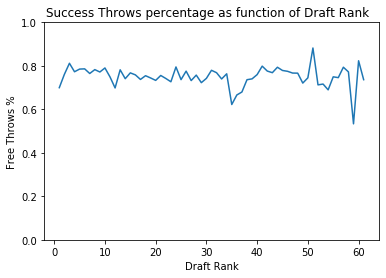

In [15]:
# Success throws precentage over time
plt.plot(list(ranks),success_precentage_by_rank)
plt.title('Success Throws percentage as function of Draft Rank  ')
plt.ylim([0,1])
plt.xlabel('Draft Rank')
plt.ylabel('Free Throws %')

As we see, there is no special trend in the graph (the FT% is between 0.7 to 0.9 for all ranks). We expected that the higher-ranked players would have better performence but we can't conclude it from the data. 

We have to take under consideration that the draft-rank data is not uniformly distributed, as we can see in the graph below, and is biased towared small values (the value 0 represents missing values, and in our case players who had no draft rank), so the barplot above needs to be normalized.

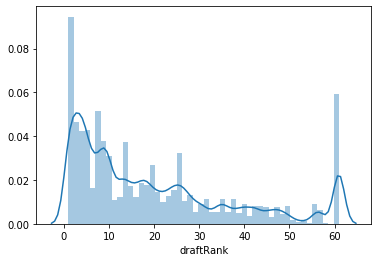

In [16]:
sns.distplot(database['draftRank'])

### The correlation between the score difference and the free-throw result

We will add a column calculating the differance.
We assume that if the difference is small in the time of the shot, the player would be more stressed and his shooting precentage would drop. 

In [17]:
difs = range(int(np.min(database['scoreDif']))+1,int(np.max(database['scoreDif']))+1)
success_precentage_by_scoreDif = []

def throws_per_dif(database,dif):    
    total = len(database[database.scoreDif == dif])
    if total == 0:
        precentage = 0.0
    else:
        made = len(database[(database.scoreDif == dif) & (database.shot_made == 1)])
        precentage = made/total
    success_precentage_by_scoreDif.append(precentage)

for dif in difs:
    throws_per_dif(database,dif)

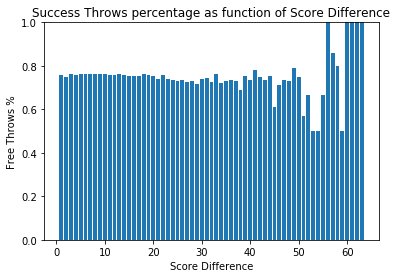

(0, 15)

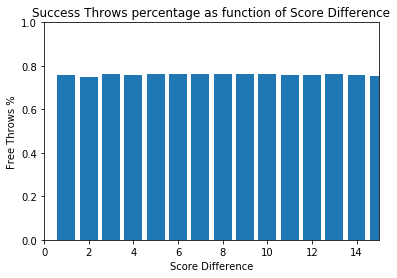

In [18]:
# Success throws precentage over time
plt.bar(list(difs),success_precentage_by_scoreDif)
plt.title('Success Throws percentage as function of Score Difference')
plt.ylim([0,1])
plt.xlabel('Score Difference')
plt.ylabel('Free Throws %')
plt.show()
plt.bar(list(difs),success_precentage_by_scoreDif)
plt.title('Success Throws percentage as function of Score Difference')
plt.ylim([0,1])
plt.xlabel('Score Difference')
plt.ylabel('Free Throws %')
plt.xlim(0,15)

At the 'Success Throws percentage as function of Score Difference' plot, it seems that our hypotesis that as long as the score difference gets bigger, so as the free-throw success precentaege is partly true. 
We can see a trend in the graph but it is not continuous.

### The correlation between the player position and the free-throw result
We want to analyze if the "Position" feature of each player could be a helpful feature that may help our prediction model.
Above we can see a plot showing the distribution of the FT% over the different positions.

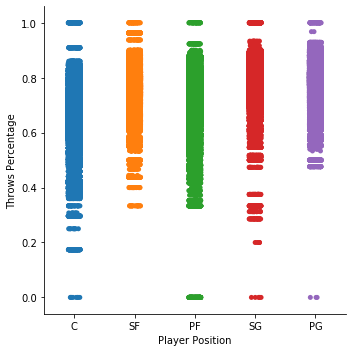

In [19]:
ax2 = sns.catplot(x="Pos", y="FT%", data=database);
#ax2 = sns.catplot(x="Pos", y="FT%",  kind="swarm", data=database);
ax2.set(xlabel='Player Position', ylabel='Throws Percentage')
plt.show()

Average FT% at each position

In [20]:
database.groupby('Pos').agg({'FT%':'mean'})

,FT%
Pos,
C,0.664836
PF,0.720946
PG,0.795977
SF,0.770927
SG,0.795559


We can see that Centers players owns the worst percentage.

Point Guards and Shouting Guards players holds the best percentage over all the positions.

Next, we will check how well our dataset represents the general population of NBA Players.
1. MSE of the FT% players achieved in their carrers and their FT% we have in the dataset.

### Our goal
We’ll try to explore two options for prediction:

•	Offline prediction: try to predict the players succes percentage (for all kinds of throws) for the current season based on his past performance and give the coach an insight about the player. 

•	Online prediction : try to predict whether a player will hit in a certain throw. 

### What's next?

- Extract more statistical analysis on our current data, find corralation between more than two parameters. 
- Pre-process our data in order to create an initial ML model.
- Achieve good results on our ML model
- Try to reduce our problem dimension/features by analyzing which features have big influence.
- "Engineer" more strong features in order to achieve dimension reduction.
- Build new ML model and achieve good results, again! YEY!
- Explain our ML model results, when it fails and why

 ### Fitting a model
 
 We will choose the relevant columns (ommiting most of the categorical variables) from our model_database

In [21]:
# changing the position variable from categorial variable to numeric variable:
from preProcess import preProcess_position
database = preProcess_position(database)

# Keep small database with original FT%
db_for_baseline_model = database[["FT%","shot_made"]]

# changing the playoff and ShootingHand to binary variables:
database['playoffs'] = database['playoffs'].map(lambda x : 0 if x == 'regular' else 1)
database['ShootingHand'] = database['ShootingHand'].map(lambda x : 0 if x == 'Right' else 1)

# modify the numeric variables Height and Weight:
database['Height'] = database['Height'].map(lambda x : int(x))
database['Weight'] = database['Weight'].map(lambda x : int(x))

# as we saw earlier, we have missing data in the 'FT%' and the '3P%' columns so we will fill the NA cells with the mode of the column
database['FT%'] = database['FT%'].fillna(database['FT%'].mode()[0])
database['3P%'] = database['3P%'].fillna(database['FT%'].mode()[0])

In [22]:
# we choose the relevant variables for our model:
continuous_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank','abs_min', 'Difference']
binary_parameters = ['playoffs', 'Pos', 'ShootingHand'] 
binary_database = pd.DataFrame(database[binary_variables])
database[continuous_parameters].describe()

,FG%,2P%,3P%,FT%,Height,Weight,draftRank,abs_min,Difference
count,617786.000000,617786.000000,617786.000000,617786.000000,617786.000000,617786.000000,617786.000000,617786.000000,617786.000000
mean,0.463961,0.489447,0.297221,0.742858,200.689611,101.170698,19.872399,27.865444,0.411400
std,0.047091,0.039687,0.117763,0.091483,9.107146,12.606636,17.926089,14.121174,10.747354
min,0.000000,0.000000,0.000000,0.000000,165.000000,61.000000,1.000000,1.000000,-63.000000
25%,0.433000,0.466000,0.279000,0.682927,193.000000,92.000000,5.000000,16.000000,-6.000000
50%,0.452000,0.482000,0.335000,0.760000,203.000000,100.000000,14.000000,29.000000,1.000000
75%,0.493000,0.510000,0.366000,0.804384,208.000000,111.000000,29.000000,40.000000,7.000000
max,0.672000,0.681000,1.000000,1.000000,229.000000,147.000000,61.000000,96.000000,59.000000


For our model, we assume that our variables are normally distributed.
We will examine this hypothesis and normalize the variables

We'll plot the distribution plot of the variables 'FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference'
(in 3 different plots because of the scale diffrence) :

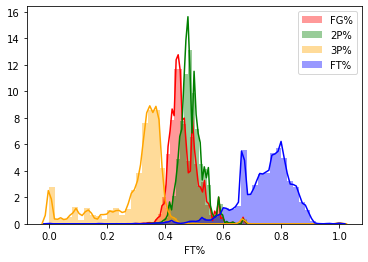

In [23]:
sns.distplot(database['FG%'], color = 'red', label = "FG%") 
sns.distplot(database['2P%'], color = 'green', label = "2P%") 
sns.distplot(database['3P%'], color = 'orange', label = "3P%") 
sns.distplot(database['FT%'], color = 'blue', label = "FT%") 
plt.legend()

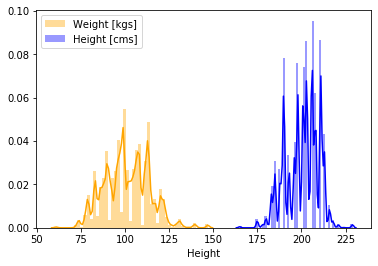

In [24]:
sns.distplot(database['Weight'], color = 'orange', label = "Weight [kgs]") 
sns.distplot(database['Height'], color = 'blue', label = "Height [cms]")
plt.legend()

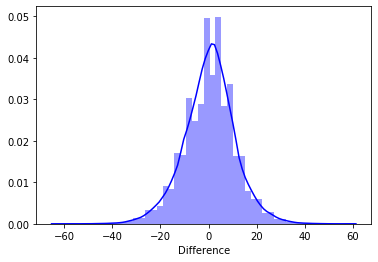

In [25]:
sns.distplot(database['Difference'], color = 'blue') 

we can see that the variables are distribute close no normal.
we'll normalise these colunms so that the mean would be 0 and the variance would be 1:

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
database[semiNormal_parameters] = sc.fit_transform(database[semiNormal_parameters]) 

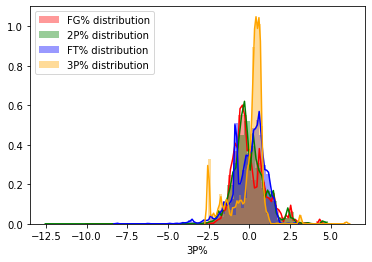

In [27]:
sns.distplot(database['FG%'], color = 'red') 
sns.distplot(database['2P%'], color = 'green') 
sns.distplot(database['FT%'], color = 'blue') 
sns.distplot(database['3P%'], color = 'orange') 
plt.legend(labels=['FG% distribution', '2P% distribution', 'FT% distribution', '3P% distribution'])
plt.show()

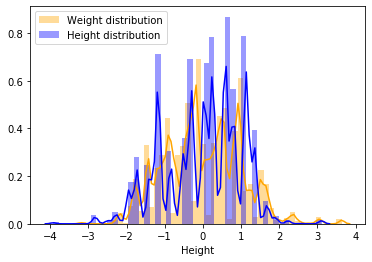

In [28]:
sns.distplot(database['Weight'], color = 'orange') 
sns.distplot(database['Height'], color = 'blue') 
plt.legend(labels=['Weight distribution', 'Height distribution'])
plt.show()

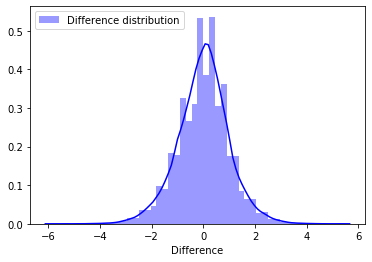

In [29]:
sns.distplot(database['Difference'], color = 'blue') 
plt.legend(labels=['Difference distribution'])
plt.show()

In all the variables above, we got mean close to 0 and std 1. 

The variables 'abs_time' and 'draftRank' , doesn't distribute semi-normal, so we will normalize them using min-max normalization:


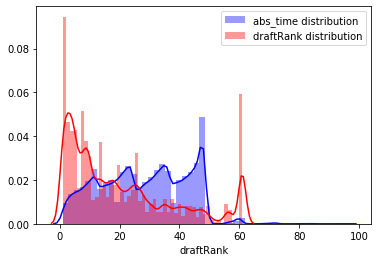

In [30]:
sns.distplot(database['abs_min'], color = 'blue', label = 'abs_min distribution') 
sns.distplot(database['draftRank'], color = 'red', label = 'draftRank distribution') 
plt.legend(labels=['abs_time distribution','draftRank distribution'])
plt.show()

In [31]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

nonNormal_parameters = ['abs_min', 'draftRank']
database[nonNormal_parameters] = mm.fit_transform(database[nonNormal_parameters])


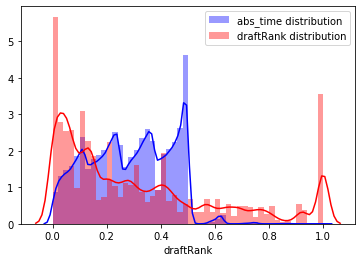

In [32]:
sns.distplot(database['abs_min'], color = 'blue', label = 'abs_min distribution') 
sns.distplot(database['draftRank'], color = 'red', label = 'draftRank distribution') 
plt.legend(labels=['abs_time distribution','draftRank distribution'])
plt.show()

In [33]:
model_parameters = ['player','playoffs', 'Pos', 'ShootingHand', 'FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank','abs_min', 'Difference','shot_made']
model_database = database[model_parameters]
model_database.describe()

,playoffs,Pos,ShootingHand,FG%,2P%,3P%,FT%,Height,Weight,draftRank,abs_min,Difference,shot_made
count,617786.000000,617786.000000,617786.000000,6.177860e+05,6.177860e+05,6.177860e+05,6.177860e+05,6.177860e+05,6.177860e+05,617786.000000,617786.000000,6.177860e+05,617786.000000
mean,0.068179,0.555441,0.093804,1.488746e-16,6.618571e-15,-4.404591e-16,-8.296677e-16,-1.135882e-15,-1.406626e-17,0.314540,0.282794,-7.222903e-18,0.756780
std,0.252053,0.224102,0.291557,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.298768,0.148644,1.000001e+00,0.429027
min,0.000000,0.200000,0.000000,-9.852348e+00,-1.233280e+01,-2.523898e+00,-8.120213e+00,-3.918861e+00,-3.186475e+00,0.000000,0.000000,-5.900192e+00,0.000000
25%,0.000000,0.500000,0.000000,-6.574712e-01,-5.907943e-01,-1.547287e-01,-6.551090e-01,-8.443498e-01,-7.274507e-01,0.066667,0.157895,-5.965566e-01,1.000000
50%,0.000000,0.500000,0.000000,-2.540008e-01,-1.876352e-01,3.208035e-01,1.873812e-01,2.536899e-01,-9.286373e-02,0.216667,0.294737,5.476704e-02,1.000000
75%,0.000000,0.800000,0.000000,6.166458e-01,5.178932e-01,5.840446e-01,6.725500e-01,8.027098e-01,7.796933e-01,0.466667,0.410526,6.130444e-01,1.000000
max,1.000000,0.800000,1.000000,4.417761e+00,4.826656e+00,5.967749e+00,2.810832e+00,3.108593e+00,3.635335e+00,1.000000,1.000000,5.451449e+00,1.000000


In [34]:
model_database.head(5)

,player,playoffs,Pos,ShootingHand,FG%,2P%,3P%,FT%,Height,Weight,draftRank,abs_min,Difference,shot_made
0,Andrew Bynum,0,0.2,0,1.954469,1.702173,-1.581325,-4.881385,1.351730,2.207514,0.150000,0.000000,0.054767,1
1,Andrew Bynum,0,0.2,0,1.954469,1.702173,-1.581325,-4.881385,1.351730,2.207514,0.150000,0.000000,0.147813,1
2,Andrew Bynum,0,0.2,0,1.954469,1.702173,-1.581325,-4.881385,1.351730,2.207514,0.150000,0.042105,-0.596557,1
3,Andrew Bynum,0,0.2,0,1.954469,1.702173,-1.581325,-4.881385,1.351730,2.207514,0.150000,0.042105,-0.596557,0
4,Shawn Marion,0,0.5,0,0.425528,0.593486,0.286837,0.984793,0.034082,-0.172187,0.133333,0.042105,0.799137,1


## Baseline Model
Predicit free-throw success only with FT% feature. No learning process or algorithm is used here.
Threshold classificator, FT% over 0.5 will be predicted as 1, else 0.

In [35]:
## Baseline model
from sklearn import metrics

baseline_predict = db_for_baseline_model["FT%"].apply(lambda x: 1 if x>=0.5 else 0)
expected = database.shot_made
print(metrics.classification_report(expected, baseline_predict))

              precision    recall  f1-score   support

           0       0.32      0.12      0.18    150258
           1       0.76      0.92      0.83    467528

    accuracy                           0.72    617786
   macro avg       0.54      0.52      0.50    617786
weighted avg       0.66      0.72      0.67    617786



## Logisitic Regression


In [36]:
v = model_database.player.value_counts()
log_reg_database = model_database[model_database.player.isin(v.index[v.gt(200)])] ## leave only players with more than 200 games.


In [37]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
v = model_database.player.value_counts()
log_reg_database = model_database[model_database.player.isin(v.index[v.gt(200)])] ## leave only players with more than 200 games.
logreg = linear_model.LogisticRegression(C=1e5)
Y = log_reg_database['shot_made']
X = log_reg_database.drop(columns=['shot_made','player'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

logreg.fit(X_train.values, y_train.values)
predictions = logreg.predict(X_test.values)
predicted_probs = logreg.predict_proba(X_test.values)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.53      0.03      0.06     46308
           1       0.76      0.99      0.86    146877

    accuracy                           0.76    193185
   macro avg       0.65      0.51      0.46    193185
weighted avg       0.71      0.76      0.67    193185



## Linear SVM Model

In [42]:
from sklearn.model_selection import train_test_split

v = model_database.player.value_counts()
linear_svm_database = model_database[model_database.player.isin(v.index[v.gt(200)])] ## leave only players with more than 200 games.
#linear_svm_database = linear_svm_database.loc[linear_svm_database['player'] == 'LeBron James']
linear_svm_database = linear_svm_database
Y = linear_svm_database['shot_made']
X = linear_svm_database.drop(columns=['shot_made','player'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [43]:
## Linear SVM Model
from sklearn.svm import SVC
print(X_train.shape)
input('hi')
linear_svm_model = SVC(kernel='linear', class_weight='balanced',verbose=True,C=1)
linear_svm_model.fit(X_train.values, y_train.values)
print("Training DONE!")
predictions = linear_svm_model.predict(X_test.values)
print(metrics.classification_report(y_test, predictions))

(392224, 12)
hi0
[LibSVM]Training DONE!
              precision    recall  f1-score   support

           0       0.33      0.44      0.38     46308
           1       0.80      0.72      0.76    146877

    accuracy                           0.65    193185
   macro avg       0.57      0.58      0.57    193185
weighted avg       0.69      0.65      0.67    193185



In [ ]:
from preProcess import run_PCA
n = 12
